Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Validation accuracy: 0.3125, epoch: 0
Validation accuracy: 0.3125, epoch: 1
Validation accuracy: 0.1875, epoch: 2
Validation accuracy: 0.4375, epoch: 3
Validation accuracy: 0.5625, epoch: 4
Validation accuracy: 0.5625, epoch: 5
Validation accuracy: 0.6875, epoch: 6
Validation accuracy: 0.5625, epoch: 7
Validation accuracy: 0.625, epoch: 8
Validation accuracy: 0.5, epoch: 9
Validation accuracy: 0.6875, epoch: 10
Early stopping due to no improvement


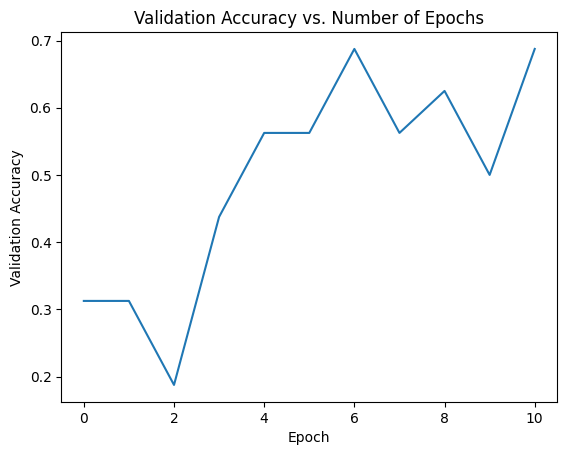

              precision    recall  f1-score   support

   Fake News       0.53      1.00      0.69        19
   Real News       1.00      0.15      0.26        20

    accuracy                           0.56        39
   macro avg       0.76      0.57      0.48        39
weighted avg       0.77      0.56      0.47        39



In [ ]:
import importlib
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

import numpy as np

package = "tensorflow"
try:
    importlib.import_module(package)
except ImportError:
    !pip install - U {package}
    importlib.import_module(package)
package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}

    importlib.import_module(package)

package = "pandas"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "sklearn"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "keras"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "torch"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "langdetect"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from langdetect import detect

from google.colab import drive
drive.mount('/content/drive')

# Check for the availability of required packages and install it
required_packages = ['tensorflow', 'transformers', 'pandas', 'sklearn', 'keras', 'torch', 'langdetect']
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        !pip install {package}
        importlib.import_module(package)


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_200.csv')
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/200lines_50pcGen.csv")


df = df.dropna(subset=['text'])
df = df.dropna(subset=['title'])

df1 = df1.dropna(subset=['text'])
df1 = df1.dropna(subset=['title'])

# Tokenization and Formatting
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize_text(dfx, max_len):
    return tokenizer.batch_encode_plus(
        dfx['text'].str.lower().tolist(),
        max_length = max_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

max_len = 256  #max length
tokens = tokenize_text(df, max_len)
tokens1 = tokenize_text(df1, max_len)

# Model Creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = model.to(device)

# Split into training and testing datasets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(tokens['input_ids'], df['label'].values, random_state=100, test_size=0.2)

# Split into training and testing datasets
train_inputs1, test_inputs1, train_labels1, test_labels1 = train_test_split(tokens1['input_ids'], df1['label'].values, random_state=100, test_size=0.2)

train_inputs, train_labels = train_inputs1, train_labels1

# Further split the training data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, random_state=100, test_size=0.1)

# Convert into torch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for the training, testing and validation set
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32,shuffle  = True)
val_data = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_data, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight decay parameter

best_acc = 0
tolerance = 0
# Keep track of the validation accuracy for each epoch
val_acc_list = []

for epoch in range(20):  # maximum of 100 epochs
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, labels=b_labels)

        loss = outputs[0]

        # Apply weight decay
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)

        loss += 0.01 * l2_regularization  # Adjust the weight decay factor

        loss.backward()
        optimizer.step()

    # After each epoch, evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    for batch in val_dataloader:
        batch = [b.to(device) for b in batch]
        b_input_ids, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()

    # Check accuracy
    acc = accuracy_score(true_labels, pred_flat)
    val_acc_list.append(acc)

    print(f'Validation accuracy: {acc}, epoch: {epoch}')

    # If this epoch is better than before, reset patience
    if acc > best_acc:
        best_acc = acc
        tolerance = 0
    else:
        # If this epoch did not improve accuracy, increase patience
        tolerance += 1
        if tolerance > 3:  # no improvement for 3 consecutive epochs
            print('Early stopping due to no improvement')
            break

# Plot validation accuracy
plt.plot(val_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Epochs')
plt.show()

# Create DataLoader for the test set
test_data = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Evaluation
model.eval()

predictions = []
true_labels = []

for batch in test_dataloader:
    batch = [b.to(device) for b in batch]
    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate evaluation on the whole dataset
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# For each input batch, pick the label (0 or 1) with the higher score
pred_flat = np.argmax(predictions, axis=1).flatten()

# Print the classification report
print(classification_report(true_labels, pred_flat, target_names=['Fake News', 'Real News']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of

Validation accuracy: 0.4358974358974359, epoch: 0
Validation accuracy: 0.46153846153846156, epoch: 1
Validation accuracy: 0.46153846153846156, epoch: 2
Validation accuracy: 0.38461538461538464, epoch: 3
Validation accuracy: 0.46153846153846156, epoch: 4
Validation accuracy: 0.7948717948717948, epoch: 5
Validation accuracy: 0.7692307692307693, epoch: 6
Validation accuracy: 0.717948717948718, epoch: 7
Validation accuracy: 0.7948717948717948, epoch: 8
Validation accuracy: 0.7435897435897436, epoch: 9
Early stopping due to no improvement


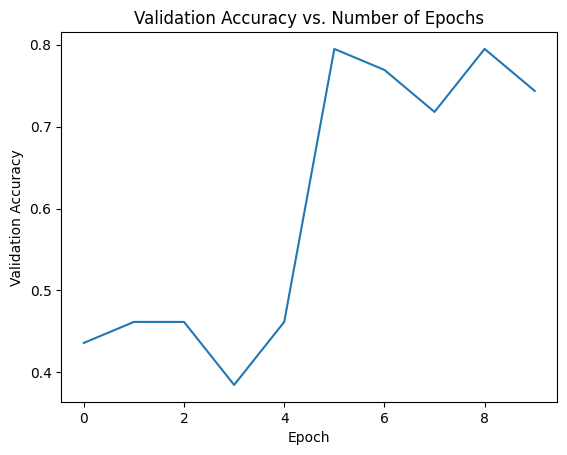

              precision    recall  f1-score   support

   Fake News       0.96      0.96      0.96        54
   Real News       0.96      0.96      0.96        45

    accuracy                           0.96        99
   macro avg       0.96      0.96      0.96        99
weighted avg       0.96      0.96      0.96        99



In [ ]:
import importlib
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

import numpy as np

package = "tensorflow"
try:
    importlib.import_module(package)
except ImportError:
    !pip install - U {package}
    importlib.import_module(package)
package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}

    importlib.import_module(package)

package = "pandas"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "sklearn"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "keras"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "torch"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "langdetect"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from langdetect import detect

from google.colab import drive
drive.mount('/content/drive')

# Check for the availability of required packages and install it
required_packages = ['tensorflow', 'transformers', 'pandas', 'sklearn', 'keras', 'torch', 'langdetect']
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        !pip install {package}
        importlib.import_module(package)


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_500.csv')
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/500lines_50pcGen.csv")


df = df.dropna(subset=['text'])
df = df.dropna(subset=['title'])

df1 = df1.dropna(subset=['text'])
df1 = df1.dropna(subset=['title'])

# Tokenization and Formatting
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize_text(dfx, max_len):
    return tokenizer.batch_encode_plus(
        dfx['text'].str.lower().tolist(),
        max_length = max_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

max_len = 256  #max length
tokens = tokenize_text(df, max_len)
tokens1 = tokenize_text(df1, max_len)

# Model Creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = model.to(device)

# Split into training and testing datasets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(tokens['input_ids'], df['label'].values, random_state=100, test_size=0.2)

# Split into training and testing datasets
train_inputs1, test_inputs1, train_labels1, test_labels1 = train_test_split(tokens1['input_ids'], df1['label'].values, random_state=100, test_size=0.2)

train_inputs, train_labels = train_inputs1, train_labels1

# Further split the training data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, random_state=100, test_size=0.1)

# Convert into torch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for the training, testing and validation set
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32,shuffle  = True)
val_data = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_data, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight decay parameter

best_acc = 0
tolerance = 0
# Keep track of the validation accuracy for each epoch
val_acc_list = []

for epoch in range(20):  # maximum of 100 epochs
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, labels=b_labels)

        loss = outputs[0]

        # Apply weight decay
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)

        loss += 0.01 * l2_regularization  # Adjust the weight decay factor

        loss.backward()
        optimizer.step()

    # After each epoch, evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    for batch in val_dataloader:
        batch = [b.to(device) for b in batch]
        b_input_ids, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()

    # Check accuracy
    acc = accuracy_score(true_labels, pred_flat)
    val_acc_list.append(acc)

    print(f'Validation accuracy: {acc}, epoch: {epoch}')

    # If this epoch is better than before, reset patience
    if acc > best_acc:
        best_acc = acc
        tolerance = 0
    else:
        # If this epoch did not improve accuracy, increase patience
        tolerance += 1
        if tolerance > 3:  # no improvement for 3 consecutive epochs
            print('Early stopping due to no improvement')
            break

# Plot validation accuracy
plt.plot(val_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Epochs')
plt.show()

# Create DataLoader for the test set
test_data = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Evaluation
model.eval()

predictions = []
true_labels = []

for batch in test_dataloader:
    batch = [b.to(device) for b in batch]
    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate evaluation on the whole dataset
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# For each input batch, pick the label (0 or 1) with the higher score
pred_flat = np.argmax(predictions, axis=1).flatten()

# Print the classification report
print(classification_report(true_labels, pred_flat, target_names=['Fake News', 'Real News']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of

Validation accuracy: 0.7612903225806451, epoch: 0
Validation accuracy: 0.7677419354838709, epoch: 1
Validation accuracy: 0.8516129032258064, epoch: 2
Validation accuracy: 0.8593548387096774, epoch: 3
Validation accuracy: 0.8980645161290323, epoch: 4
Validation accuracy: 0.8851612903225806, epoch: 5
Validation accuracy: 0.8941935483870967, epoch: 6
Validation accuracy: 0.8851612903225806, epoch: 7
Validation accuracy: 0.9058064516129032, epoch: 8
Validation accuracy: 0.912258064516129, epoch: 9
Validation accuracy: 0.8993548387096775, epoch: 10
Validation accuracy: 0.9161290322580645, epoch: 11
Validation accuracy: 0.895483870967742, epoch: 12
Validation accuracy: 0.8929032258064517, epoch: 13
Validation accuracy: 0.9161290322580645, epoch: 14
Validation accuracy: 0.9058064516129032, epoch: 15
Early stopping due to no improvement


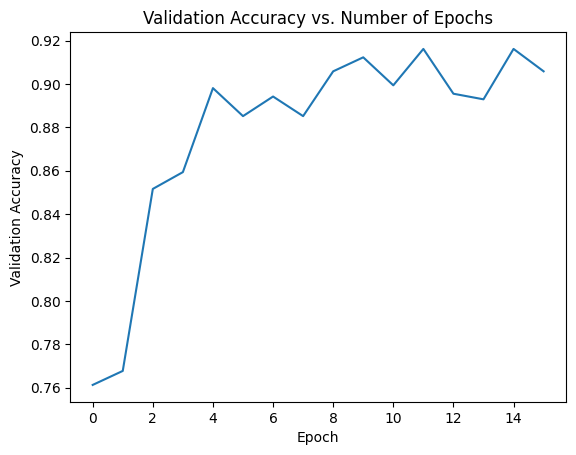

              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      1029
   Real News       1.00      1.00      1.00       912

    accuracy                           1.00      1941
   macro avg       1.00      1.00      1.00      1941
weighted avg       1.00      1.00      1.00      1941



In [ ]:
import importlib
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

import numpy as np

package = "tensorflow"
try:
    importlib.import_module(package)
except ImportError:
    !pip install - U {package}
    importlib.import_module(package)
package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}

    importlib.import_module(package)

package = "pandas"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "sklearn"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "keras"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "torch"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "langdetect"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from langdetect import detect

from google.colab import drive
drive.mount('/content/drive')

# Check for the availability of required packages and install it
required_packages = ['tensorflow', 'transformers', 'pandas', 'sklearn', 'keras', 'torch', 'langdetect']
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        !pip install {package}
        importlib.import_module(package)


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_10000.csv')
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/10000lines_50pcGen.csv")


df = df.dropna(subset=['text'])
df = df.dropna(subset=['title'])

df1 = df1.dropna(subset=['text'])
df1 = df1.dropna(subset=['title'])

# Tokenization and Formatting
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize_text(dfx, max_len):
    return tokenizer.batch_encode_plus(
        dfx['text'].str.lower().tolist(),
        max_length = max_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

max_len = 256  #max length
tokens = tokenize_text(df, max_len)
tokens1 = tokenize_text(df1, max_len)

# Model Creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = model.to(device)

# Split into training and testing datasets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(tokens['input_ids'], df['label'].values, random_state=100, test_size=0.2)

# Split into training and testing datasets
train_inputs1, test_inputs1, train_labels1, test_labels1 = train_test_split(tokens1['input_ids'], df1['label'].values, random_state=100, test_size=0.2)

train_inputs, train_labels = train_inputs1, train_labels1

# Further split the training data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, random_state=100, test_size=0.1)

# Convert into torch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for the training, testing and validation set
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32,shuffle  = True)
val_data = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_data, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight decay parameter

best_acc = 0
tolerance = 0
# Keep track of the validation accuracy for each epoch
val_acc_list = []

for epoch in range(20):  # maximum of 100 epochs
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, labels=b_labels)

        loss = outputs[0]

        # Apply weight decay
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)

        loss += 0.01 * l2_regularization  # Adjust the weight decay factor

        loss.backward()
        optimizer.step()

    # After each epoch, evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    for batch in val_dataloader:
        batch = [b.to(device) for b in batch]
        b_input_ids, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()

    # Check accuracy
    acc = accuracy_score(true_labels, pred_flat)
    val_acc_list.append(acc)

    print(f'Validation accuracy: {acc}, epoch: {epoch}')

    # If this epoch is better than before, reset patience
    if acc > best_acc:
        best_acc = acc
        tolerance = 0
    else:
        # If this epoch did not improve accuracy, increase patience
        tolerance += 1
        if tolerance > 3:  # no improvement for 3 consecutive epochs
            print('Early stopping due to no improvement')
            break

# Plot validation accuracy
plt.plot(val_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Epochs')
plt.show()

# Create DataLoader for the test set
test_data = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Evaluation
model.eval()

predictions = []
true_labels = []

for batch in test_dataloader:
    batch = [b.to(device) for b in batch]
    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate evaluation on the whole dataset
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# For each input batch, pick the label (0 or 1) with the higher score
pred_flat = np.argmax(predictions, axis=1).flatten()

# Print the classification report
print(classification_report(true_labels, pred_flat, target_names=['Fake News', 'Real News']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of

Validation accuracy: 0.8945409429280397, epoch: 0
Validation accuracy: 0.9063275434243176, epoch: 1
Validation accuracy: 0.9181141439205955, epoch: 2
Validation accuracy: 0.9081885856079405, epoch: 3
Validation accuracy: 0.9181141439205955, epoch: 4
Validation accuracy: 0.9193548387096774, epoch: 5
Validation accuracy: 0.9156327543424317, epoch: 6
Validation accuracy: 0.9162531017369727, epoch: 7
Validation accuracy: 0.9137717121588089, epoch: 8
Validation accuracy: 0.9181141439205955, epoch: 9
Early stopping due to no improvement


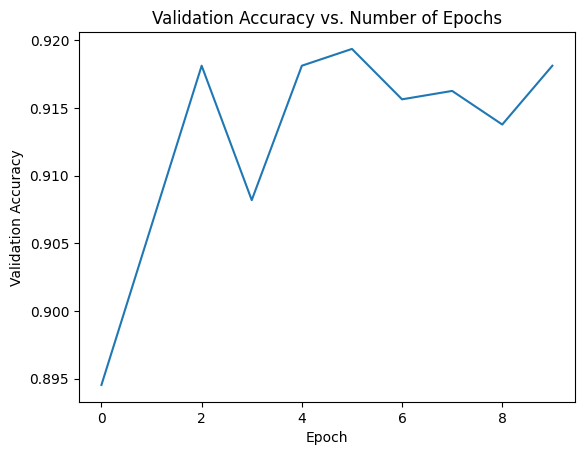

              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      2104
   Real News       1.00      1.00      1.00      1937

    accuracy                           1.00      4041
   macro avg       1.00      1.00      1.00      4041
weighted avg       1.00      1.00      1.00      4041



In [ ]:
import importlib
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

import numpy as np

package = "tensorflow"
try:
    importlib.import_module(package)
except ImportError:
    !pip install - U {package}
    importlib.import_module(package)
package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}

    importlib.import_module(package)

package = "pandas"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "sklearn"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "keras"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "torch"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "transformers"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

package = "langdetect"
try:
    importlib.import_module(package)
except ImportError:
    !pip install {package}
    importlib.import_module(package)

import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from langdetect import detect

from google.colab import drive
drive.mount('/content/drive')

# Check for the availability of required packages and install it
required_packages = ['tensorflow', 'transformers', 'pandas', 'sklearn', 'keras', 'torch', 'langdetect']
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        !pip install {package}
        importlib.import_module(package)


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/full_dataset_50pcGen.csv")


df = df.dropna(subset=['text'])
df = df.dropna(subset=['title'])

df1 = df1.dropna(subset=['text'])
df1 = df1.dropna(subset=['title'])

# Tokenization and Formatting
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize_text(dfx, max_len):
    return tokenizer.batch_encode_plus(
        dfx['text'].str.lower().tolist(),
        max_length = max_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

max_len = 256  #max length
tokens = tokenize_text(df, max_len)
tokens1 = tokenize_text(df1, max_len)

# Model Creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = model.to(device)

# Split into training and testing datasets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(tokens['input_ids'], df['label'].values, random_state=100, test_size=0.2)

# Split into training and testing datasets
train_inputs1, test_inputs1, train_labels1, test_labels1 = train_test_split(tokens1['input_ids'], df1['label'].values, random_state=100, test_size=0.2)

train_inputs, train_labels = train_inputs1, train_labels1

# Further split the training data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, random_state=100, test_size=0.1)

# Convert into torch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for the training, testing and validation set
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32,shuffle  = True)
val_data = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_data, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight decay parameter

best_acc = 0
tolerance = 0
# Keep track of the validation accuracy for each epoch
val_acc_list = []

for epoch in range(20):  # maximum of 100 epochs
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, labels=b_labels)

        loss = outputs[0]

        # Apply weight decay
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)

        loss += 0.01 * l2_regularization  # Adjust the weight decay factor

        loss.backward()
        optimizer.step()

    # After each epoch, evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    for batch in val_dataloader:
        batch = [b.to(device) for b in batch]
        b_input_ids, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    pred_flat = np.argmax(predictions, axis=1).flatten()

    # Check accuracy
    acc = accuracy_score(true_labels, pred_flat)
    val_acc_list.append(acc)

    print(f'Validation accuracy: {acc}, epoch: {epoch}')

    # If this epoch is better than before, reset patience
    if acc > best_acc:
        best_acc = acc
        tolerance = 0
    else:
        # If this epoch did not improve accuracy, increase patience
        tolerance += 1
        if tolerance > 3:  # no improvement for 3 consecutive epochs
            print('Early stopping due to no improvement')
            break

# Plot validation accuracy
plt.plot(val_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Epochs')
plt.show()

# Create DataLoader for the test set
test_data = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

# Evaluation
model.eval()

predictions = []
true_labels = []

for batch in test_dataloader:
    batch = [b.to(device) for b in batch]
    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate evaluation on the whole dataset
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# For each input batch, pick the label (0 or 1) with the higher score
pred_flat = np.argmax(predictions, axis=1).flatten()

# Print the classification report
print(classification_report(true_labels, pred_flat, target_names=['Fake News', 'Real News']))

# New Section